## MLA and RLD Fitting Op

### Dataset Input

Add required dependencies and read the time-resolved transient data from *input.sdt*.

In [1]:
%classpath config resolver imagej.public https://maven.imagej.net/content/groups/public
%classpath add mvn io.scif scifio-lifesci 0.8.0
%classpath add mvn net.imagej imagej 2.0.0-rc-67
%classpath add mvn net.imglib2 imglib2-roi 0.5.2
%classpath add mvn org.scijava native-lib-loader 2.3.0
%classpath add jar ../target/slim-curve-1.0.0-SNAPSHOT.jar
%classpath add jar ../target/slim-curve-1.0.0-SNAPSHOT-natives-windows_64.jar
%classpath add jar ../target/slim-plugin-0.1.0-SNAPSHOT.jar

import net.imagej.ImageJ

ij = new ImageJ()
op = ij.op()
nb = ij.notebook()
sdt = ij.scifio().datasetIO().open("../input.sdt")

Added new repo: imagej.public


[INFO] Reading SDT header


input.sdt

The acquired dataset is a 4-dimensional image with metadata:<br>
*(Only the one channel is shown)*

[INFO] Reading SDT header
Dim #0: size: 128, type: X
Dim #1: size: 128, type: Y
Dim #2: size:  64, type: Lifetime
Dim #3: size:  16, type: Spectra
Time base: 12.500000, number of bins: 64


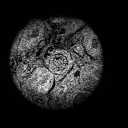

In [2]:
import io.scif.lifesci.SDTFormat

sdtReader = new SDTFormat.Reader()
sdtReader.setContext(ij.getContext())
sdtReader.setSource("../input.sdt")
sdtMetadata = sdtReader.getMetadata()

// display the axis type of each dimension
for (d = 0; d < sdt.numDimensions(); d++) {
    printf("Dim #%d: size: %3d, type: %s\n", d, sdt.dimension(d), sdt.axis(d).type())
}

timeBase = sdtMetadata.getTimeBase()
timeBins = sdtMetadata.getTimeBins()

printf("Time base: %6f, number of bins: %d\n", timeBase, timeBins)

// show the intensity of channel 12 at frame 10
tFixed = op.transform().hyperSliceView(sdt, 3, 12)
sample = op.transform().hyperSliceView(tFixed, 2, 10)

nb.display(sample)

### Basic Usage

Both of the fitting ops takes the transient data (`in`), the fitting parameter (`params`) and the Lifetime axis index (`lifetimeAxis`). The rigion of interest (`roi`) and binning settings (`binningKnl`, `binningAxes`) are optional (see below). An output image will be automatically created if a pre-allocated one (`out`) is not provided. 

In [3]:
op.help("slimFitter.fitRAI.rld")

Available operations:
	(RandomAccessibleInterval out?) =
	net.imagej.slim.DefaultFitRAI$RLDFitRAI(
		RandomAccessibleInterval out?,
		RandomAccessibleInterval in,
		FitParams params,
		int lifetimeAxis,
		RealMask roi?,
		Shape binningKnl?,
		int[] binningAxes?)

Prior to fitting, we set up some fitting parameters specifying how the fitting is done, as described below:

In [4]:
import net.imagej.slim.utils.FitParams
import slim.FitFunc
import slim.NoiseType
import slim.RestrainType

// create a new fitting parameter set
param = new FitParams()
// the iterative fitting routine will stop when chi-squared improvement is less than param.chisq_delta
param.chisq_delta = 0.0001f
// the confidence interval when calculating the error axes (95% here)
param.chisq_percent = 95
// the routine will also stop when chi-squared < param.chisq_target
param.chisq_target = 1
// when does the decay start and end?
param.fitStart = 9
param.fitEnd = 20
// the deacy model to use, in this case y(t) = Z + A * e^(-t / TAU)
param.fitFunc = FitFunc.GCI_MULTIEXP_TAU
// assume the data noise follows a Poisson distribution
param.noise = NoiseType.NOISE_GAUSSIAN_FIT
// the standard deviation at each data point in y
// NB: if NoiseType.NOISE_GIVEN is used, param.sig should be passed in
param.sig = null
// initial Z, A and TAU
param.param = [ 0, 0, 0 ]
// all three parameters above will be fitted
param.paramFree = [ true, true, true ]
// use the default restrain type
param.restrain = RestrainType.ECF_RESTRAIN_DEFAULT
// the time difference between two consecutive bins (ns)
param.xInc = timeBase / timeBins

0.1953125022824409

Once everything is set up, the fitting routine can be started:

In [5]:
// spin!
rldFitted = ij.op().run("slimFitter.fitRAI.rld", null, sdt, param, 2)

ArrayImg [128x128x3x16]

It will generate an image of the same size as the input dataset in every dimensions except for Lifetime. The Lifetime axis has now become the _"Parameter axis"_, with each value denoting a fitted parameter. E.g. (2, 1, 0, 10) is the _Z_ for coordinate X=2, Y=1, Spectra=10; (2, 1, 1, 10) is the *A* for coordinate X=2, Y=1, Spectra=10 and so on. The following shows the fitted _TAU_ values of Spectra channel 12:

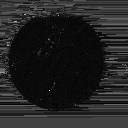

In [6]:
// show the TAUs of channel 12
tFixed = op.transform().hyperSliceView(rldFitted, 3, 12)
sample = op.transform().hyperSliceView(tFixed, 2, 2)
nb.display(sample)

While the RLD fitting op can be used to quickly but roughly estimate the model parameters, another MLA fit can be used with it in conjunction to give more accurate results (lower chi-squared). To do that, either `param.param` should be set to an well approximated initial values, or `param.paramRA` should be set to a per-pixel estimation provided by an RLD fit with the same fitting parameters. MLA fit can easily fail if the initial values are way off the final results.

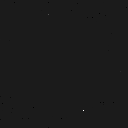

In [7]:
// param.paramRA can be used to pass pixel-specific estimated parameter (Z, A, TAU) values to
// the MLA fitting routine, which will fail on inaccurate initial values
param.paramRA = rldFitted
mlaFitted = ij.op().run("slimFitter.fitRAI.mla", null, sdt, param, 2)

tFixed = op.transform().hyperSliceView(mlaFitted, 3, 12)
sample = op.transform().hyperSliceView(tFixed, 2, 2)
nb.display(sample)

### Region of Interest

Sometimes, instead of the whole dataset, only part of the image (e.g. the region near the nucleus) are of our interest. By specifying the `roi` parameter, we neglect unwanted parts outside of it during fitting. This greatly improves the running time on large images.

In [8]:
import net.imglib2.roi.geom.real.OpenWritableBox

// X, Y, Spectra bounds
min = [ 40, 40, 10 ]
max = [ 87, 87, 15 ]

// define our region of interest, in this case [40, 87] * [40, 87], channel 10 through 15
roi = new OpenWritableBox([ min[0] - 1, min[1] - 1, min[2] - 1 ] as double[], [ max[0] + 1, max[1] + 1, max[2] + 1 ] as double[])

net.imglib2.roi.geom.real.OpenWritableBox@21e2

We start the fitting routine the same way as before but with the `roi` parameter:

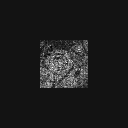

In [9]:
// spin!
rldFitted = ij.op().run("slimFitter.fitRAI.rld", null, sdt, param, 2, roi)

param.paramRA = rldFitted
mlaFitted = ij.op().run("slimFitter.fitRAI.mla", null, sdt, param, 2, roi)

// show the TAUs of channel 12
tFixed = op.transform().hyperSliceView(mlaFitted, 3, 12)
sample = op.transform().hyperSliceView(tFixed, 2, 0)
nb.display(sample)
// // ij.notebook().display(paramImg)
// // ui.show(paramImg)
// // ij.op().getPlugins()
// spectraSlices = [:]
// tFixed = op.transform().hyperSliceView(paramImg, 2, 12)
// a = op.transform().hyperSliceView(tFixed, 2, 10)
// for (i = 0; i < 1; i++) {
//     spectraSlices.put("Chanel #" + i, paramImg)
// //     nb.display(ij.op().transform().hyperSliceView(tFixed, 2, 10))
// }

// // [spectraSlices]

In the results above, all other regions outside the box is neglected.

### Binning

If, for example, the dataset is too noisy and/or the average intensity is too low, binning of neighboring pixels in the XY-plane can be enabled by specifying `binningKnl` and `binningAxes`.<br>
`binningKnl` defines a **kernel** for each pixel **with the given size and shape** (e.g. a 3\*3 square) within which averaging of the neighborhood will be performed to replace the central value.<br>
`binningAxes` specifies the axis along which the kernel is expanded. In most cases, those are the **indices of X and Y axes**. One can include the Spectra axis to take pixels in the XY-neighborhood but in near-by spectra channels into account, but it may not make sense to do so.

In [10]:
import net.imglib2.algorithm.neighborhood.RectangleShape

// NB: the kernel should not include the center, as specifed by `skipCenter=true` in this case.
binningShape = new RectangleShape(1, true)
// X and Y axes
binningAxes = [ 0, 1 ] as int[]

[0, 1]

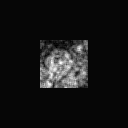

In [11]:
// spin!
rldFitted = ij.op().run("slimFitter.fitRAI.rld", null, sdt, param, 2, roi, binningShape, binningAxes)

param.paramRA = rldFitted
mlaFitted = ij.op().run("slimFitter.fitRAI.mla", null, sdt, param, 2, roi, binningShape, binningAxes)

// show the TAUs of channel 12
tFixed = op.transform().hyperSliceView(mlaFitted, 3, 12)
sample = op.transform().hyperSliceView(tFixed, 2, 0)
nb.display(sample)

NB: although binning may be useful in smoothing out noises, the resolution of the result may be lowered.